# Train ResNet18 easy
**triplet loss is calculated on all the triplets**

- Epoch: 120
- LR: 0.005
- Optimizer: Adam default
- Batch size: 32
- Margin: 0.5

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as tf
import matplotlib.pyplot as plt
from torch.autograd import Variable
import pandas as pd
import seaborn as sns
from math import sqrt
from PIL import Image
import torch.utils.data as data
from torch.nn import functional as F
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
import time
import os
import math
import copy
import json
import random

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(20)

## customized dataset
All the people with more than 1 image available will be potential anchor, and this customized dataset has 1184 names of potential anchor for training and 496 for evaluation. In every epoch, a name is picked in order and two images of that person will be selected randomly, one as *anchor* and the other as *positive*. Then an image of other than that person will be selected randomly from the whole dataset and used as *negative*.  

In [3]:
class IFWdataset(data.Dataset):
    
    def __init__(self, phase):
        
        self.endidx = {'train': 4037, 'test': 1710}.get(phase)
        self.root = '../input/lfwaligned/' + phase + '2/' + phase + '2'
        self.all_frame = pd.read_csv('../input/lfwaligned/people' + phase + '.csv')
        self.anc_frame = self.all_frame.loc[self.all_frame.images > 1]
        
        
    def __getitem__(self, index):
        
        anc_name, anc_img_num = self.anc_frame.iloc[index]
        anc_id, pos_id = random.sample(range(1, anc_img_num+1), 2)
        
        neg_name = anc_name
        while neg_name == anc_name:
            n = random.randint(0,self.endidx)
            neg_name, neg_img_num = self.all_frame.iloc[n]
        neg_id = random.randint(1,neg_img_num)
        
        
        anc = anc_name + '_' + ('000'+ str(anc_id))[-4:] + '.jpg'
        anc = Image.open(os.path.join(self.root,anc))
        anc = tf.resize(anc, (224,224))
        anc = transforms.RandomHorizontalFlip(p=0.5)(anc)
        anc = tf.to_tensor(anc)
        anc = tf.normalize(anc, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        pos = anc_name + '_' + ('000'+ str(pos_id))[-4:] + '.jpg'
        pos = Image.open(os.path.join(self.root,pos))
        pos = tf.resize(pos, (224,224))
        pos = transforms.RandomHorizontalFlip(p=0.5)(pos)
        pos = tf.to_tensor(pos)
        pos = tf.normalize(pos, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        neg = neg_name + '_' + ('000'+ str(neg_id))[-4:] + '.jpg'
        neg = Image.open(os.path.join(self.root,neg))
        neg = tf.resize(neg, (224,224))
        neg = transforms.RandomHorizontalFlip(p=0.5)(neg)
        neg = tf.to_tensor(neg)
        neg = tf.normalize(neg, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        
        return anc, pos, neg
   

    def __len__(self):
        return len(self.anc_frame) # train 1184, test 496

## ResNet18 without embedding

In [4]:
# ResNet with available versions: 18, 34, 50, 101,152

# block for small version of resnet
class Block_s(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(Block_s,self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)  
        self.bn2   = nn.BatchNorm2d(out_planes)
        self.downsample = downsample
        
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out
    
# block for large version of resnet
class Block_l(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, downsample=None):
        super(Block_l,self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)  
        self.bn2   = nn.BatchNorm2d(out_planes)
        self.conv3 = nn.Conv2d(out_planes, out_planes*4, kernel_size=1, stride=1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_planes*4)
        self.relu  = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out
        
        
class Resnet(nn.Module):
    def __init__(self, version=18, num_classes=128):
        self.v = version
        self.v_dic = {18:[2,2,2,2,512], 34:[3,4,6,3,512], 50:[3,4,6,3,2048], 101:[3,4,23,3,2048], 152:[3,8,36,3,2048]}
        self.in_planes = 64
        
        super(Resnet,self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
        self.conv2_x = self.make_layers(self.v_dic[version][0], stride=1, planes=64)
        self.conv3_x = self.make_layers(self.v_dic[version][1], stride=2, planes=128)
        self.conv4_x = self.make_layers(self.v_dic[version][2], stride=2, planes=256)
        self.conv5_x = self.make_layers(self.v_dic[version][3], stride=2, planes=512)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(self.v_dic[version][4], num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def make_layers(self, repeat_times, stride, planes):
        if self.v < 50:
            downsample = None
            if stride!=1:
                downsample = nn.Sequential(
                    nn.Conv2d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes)
                )
            layers=[]
            layers.append(Block_s(self.in_planes, planes, stride, downsample))
            self.in_planes = planes
            for i in range(repeat_times-1):
                layers.append(Block_s(self.in_planes, planes))
            return nn.Sequential(*layers)
            
        else:
            downsample = nn.Sequential(
                    nn.Conv2d(self.in_planes, planes*4,kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(planes*4)
            )
            layers=[]
            layers.append(Block_l(self.in_planes, planes, stride, downsample))
            self.in_planes = planes*4
            for i in range(repeat_times-1):
                layers.append(Block_l(self.in_planes, planes))
            return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxPool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x =self.fc(x)
        
        return x

In [5]:
def L2_distance(x1,x2):
    assert x1.size() == x2.size()
    eps = 1e-4 / x1.size(1)
    diff = torch.abs(x1 - x2)
    out = torch.pow(diff, 2).sum(dim=1)
    return torch.pow(out + eps, 1./2)


class TripletMarginLoss(nn.Module):
    def __init__(self, margin):
        super(TripletMarginLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        d_p = L2_distance(anchor, positive)
        d_n = L2_distance(anchor, negative)
        dist_hinge = F.relu(self.margin + d_p - d_n)
        loss = torch.mean(dist_hinge)
        return loss

In [6]:
import operator
from sklearn.model_selection import KFold
from scipy import interpolate

def evaluate(distances, labels, nrof_folds=10):
    thresholds=np.arange(0, 30, 0.01)
    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, distances[train_set], labels[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _ = calculate_accuracy(threshold, distances[test_set], labels[test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], distances[test_set], labels[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
    accuracy = np.mean(accuracy)
    return tpr, fpr, accuracy


def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc

In [7]:
def visualize_accuracy(statistics, fig_name):
    sns.set(style="white")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc,other) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label = phase)
        ax1.set(xlabel = 'epoch', ylabel='loss',title='loss at the xth epoch');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist)), acc_hist, label = phase)
        ax2.set(xlabel = 'epoch', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.legend();
    fig.savefig(fig_name)


def plot_roc(statistics,fig_name):
    fig = plt.figure()
    lw = 2
    fpr = statistics['train'][2][1]
    tpr = statistics['train'][2][2]
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='train ROC (area = %0.2f)' % roc_auc)
    fpr, tpr = statistics['eval'][2]
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='g',
             lw=lw, label='eval ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    fig.savefig(fig_name)
    
    
def plot_hardsmaple(statistics,fig_name):
    fig = plt.figure()
    y = statistics['train'][2][0]

    plt.plot(np.arange(len(y)), y)
    plt.xlabel('epoch')
    plt.ylabel('# train hard sample')
    plt.title('# train hardsample at the xth epoch')
    fig.savefig(fig_name)

In [8]:
def train_model(model, criterion, optimizer, scheduler=None):
    
    train_begin = time.time()
    min_loss = 100.0
    best_model_wts = copy.deepcopy(model.state_dict())
    statistics = {'train':[[],[],[[]]], 'eval':[[],[],[]]} # 'train':[[loss],[acc],[[#hard sample],[fpr],[tpr]]]  
                                                            # 'eval' :[[loss],[acc],[[fpr],[tpr]]]
    for epoch in range(1,EPOCH+1):
        print('Epoch {}/{}'.format(epoch, EPOCH))
        print('-' * 10)
        
        model.train()
        running_loss = 0.0
#         trained_size = 0
        labels, distances = [], []
        
        for (anc, pos, neg) in trainLoader:
            
            wrap = (anc, pos, neg)
            (anc, pos, neg) = [i.cuda() for i in wrap]
            out_a, out_p, out_n = model(anc), model(pos), model(neg)
            
            d_p = L2_distance(out_a, out_p)
            d_n = L2_distance(out_a, out_n)

            keep = (d_n - d_p < MARGIN)
            hard_triplets = torch.where(keep == 1)[0]
            
            if len(hard_triplets) == 0:
                continue

            out_a_s = out_a[hard_triplets]
#             out_p_s = out_p[hard_triplets]
#             out_n_s = out_n[hard_triplets]
            
#             trained_size += out_a_s.size(0)
            
            optimizer.zero_grad()
            triple_loss = criterion(out_a, out_p, out_n)

            triple_loss.backward()
            optimizer.step()
            
            running_loss += triple_loss.item() * out_a.size(0)
            
            dists = L2_distance(out_a,out_n)
            distances.append(dists.data.cpu().numpy())
            labels.append(np.zeros(dists.size(0)))

            dists = L2_distance(out_a,out_p)
            distances.append(dists.data.cpu().numpy())
            labels.append(np.ones(dists.size(0)))
        
    
        epoch_loss = running_loss / trainSize
        
        labels = np.array([sublabel for label in labels for sublabel in label])
        distances = np.array([subdist for dist in distances for subdist in dist])
        tpr, fpr, epoch_acc = evaluate(distances,labels)
        
        statistics['train'][0].append(epoch_loss)
        statistics['train'][1].append(epoch_acc)
        statistics['train'][2][0].append(out_a_s.size(0))
        if epoch==EPOCH:
            statistics['train'][2].append(list(fpr))
            statistics['train'][2].append(list(tpr))
        
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        
        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            labels, distances = [], []

            for (anc, pos, neg) in evalLoader:

                wrap = (anc, pos, neg)
                (anc, pos, neg) = [i.cuda() for i in wrap]
                out_a, out_p, out_n = model(anc), model(pos), model(neg)
                
                triple_loss = criterion(out_a, out_p, out_n)
                running_loss += triple_loss.item() * anc.size(0)
                
                dists = L2_distance(out_a,out_n)
                distances.append(dists.data.cpu().numpy())
                labels.append(np.zeros(dists.size(0)))

                dists = L2_distance(out_a,out_p)
                distances.append(dists.data.cpu().numpy())
                labels.append(np.ones(dists.size(0)))

            epoch_loss = running_loss / evalSize
            labels = np.array([sublabel for label in labels for sublabel in label])
            distances = np.array([subdist for dist in distances for subdist in dist])
            tpr, fpr, epoch_acc = evaluate(distances,labels)
            
            statistics['eval'][0].append(epoch_loss)
            statistics['eval'][1].append(epoch_acc)
            if epoch==EPOCH:
                statistics['eval'][2]=[list(fpr),list(tpr)]
            print('Eval Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print()
        
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    train_length = time.time() - train_begin
    print('Training complete in {:.0f}m {:.0f}s'.format(train_length // 60, train_length % 60))
    print('Min train loss: {:4f}'.format(min_loss))
    model.load_state_dict(best_model_wts)
    
    return model, statistics

## assign parameters

In [9]:
global DEVICE
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')


LR = 0.005
EPOCH = 120
BATCH_SIZE = 32
NUM_WORKS = 8
MARGIN = 0.5

trainSet = IFWdataset('train')
trainLoader = DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

evalSet = IFWdataset('test')
evalLoader = DataLoader(evalSet, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

trainSize = len(trainSet)
evalSize = len(evalSet)
print(trainSize)
print(evalSize)

model = Resnet().cuda()
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
criterion = TripletMarginLoss(margin=MARGIN)

1184
496


## run and plot

In [10]:
model, statistics = train_model(model, criterion, optimizer, scheduler=None)

Epoch 1/120
----------
Train Loss: 1.1932 Acc: 0.5296
Eval Loss: 1.0427 Acc: 0.5324

Epoch 2/120
----------
Train Loss: 0.7141 Acc: 0.5347
Eval Loss: 0.5873 Acc: 0.5674

Epoch 3/120
----------
Train Loss: 0.5229 Acc: 0.5663
Eval Loss: 0.5143 Acc: 0.5413

Epoch 4/120
----------
Train Loss: 0.5017 Acc: 0.5689
Eval Loss: 0.4263 Acc: 0.5646

Epoch 5/120
----------
Train Loss: 0.4444 Acc: 0.5773
Eval Loss: 0.4517 Acc: 0.5504

Epoch 6/120
----------
Train Loss: 0.4120 Acc: 0.5866
Eval Loss: 0.4774 Acc: 0.5727

Epoch 7/120
----------
Train Loss: 0.4210 Acc: 0.6018
Eval Loss: 0.5215 Acc: 0.5454

Epoch 8/120
----------
Train Loss: 0.4164 Acc: 0.5988
Eval Loss: 0.4343 Acc: 0.5856

Epoch 9/120
----------
Train Loss: 0.3996 Acc: 0.5984
Eval Loss: 0.4261 Acc: 0.5998

Epoch 10/120
----------
Train Loss: 0.3775 Acc: 0.6068
Eval Loss: 0.3767 Acc: 0.6352

Epoch 11/120
----------
Train Loss: 0.3763 Acc: 0.6119
Eval Loss: 0.3973 Acc: 0.6028

Epoch 12/120
----------
Train Loss: 0.3664 Acc: 0.6385
Eval Los

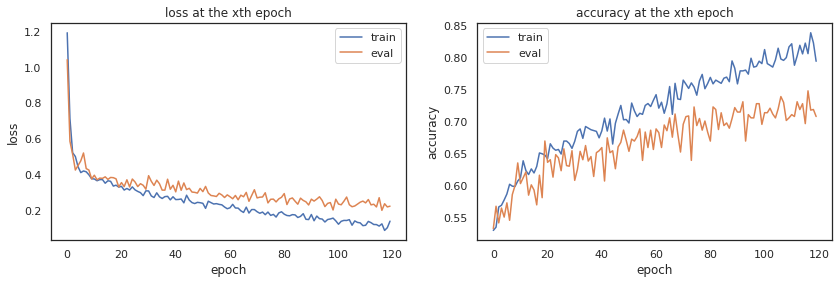

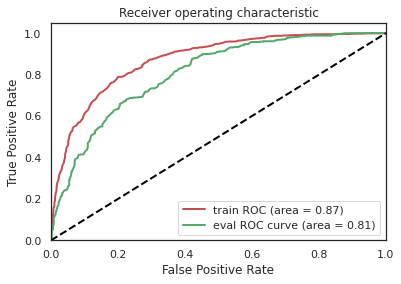

In [11]:
name = 'FN_res18_easy'
torch.save(model.state_dict(), '/kaggle/working/'+name+'.pth')
json.dump(statistics, open(name+'.json', 'w'))
visualize_accuracy(statistics, name+'.png')
plot_roc(statistics,name+'_auc.png')

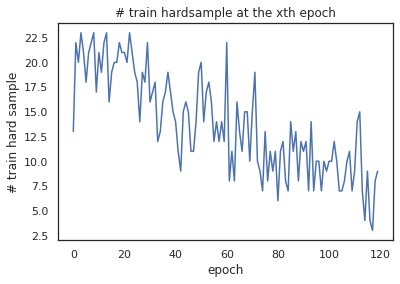

In [12]:
plot_hardsmaple(statistics,name+'_#hard.png')